#### Import libraries and load our data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, plot_roc_curve, roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Load datasets
train = pd.read_csv('../CapstoneTwo/train_final.csv')
test = pd.read_csv('../CapstoneTwo/test_final.csv')

#### Identify our dependent and independent variables

In [4]:
#Get X and y
X = train.drop(columns='WnvPresent')._get_numeric_data()
y = train['WnvPresent']

#### Split the data into train and test subsamples

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Oversample

In [6]:
os = SMOTE()
X_train, y_train = os.fit_resample(X_train, y_train)

#### Scale data to prep for model creation

In [7]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [8]:
X_train.head()

,Latitude,Longitude,Year,Month,Week,Day,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Tmax_1w,Tmax_2w,Tmax_3w,Tmin_1w,Tmin_2w,Tmin_3w,Tavg_1w,Tavg_2w,Tavg_3w,Depart_1w,Depart_2w,Depart_3w,DewPoint_1w,DewPoint_2w,DewPoint_3w,WetBulb_1w,WetBulb_2w,WetBulb_3w,Heat_1w,Heat_2w,Heat_3w,Cool_1w,Cool_2w,Cool_3w,PrecipTotal_1w,PrecipTotal_2w,PrecipTotal_3w,StnPressure_1w,StnPressure_2w,StnPressure_3w,SeaLevel_1w,SeaLevel_2w,SeaLevel_3w,ResultSpeed_1w,ResultSpeed_2w,ResultSpeed_3w,ResultDir_1w,ResultDir_2w,ResultDir_3w,AvgSpeed_1w,AvgSpeed_2w,AvgSpeed_3w
0,0.596795,0.693036,1.000000,0.8,0.842105,0.850746,0.0,0.0,1.0,0.0,0.0,0.0,0.679487,0.771429,0.753623,0.866667,0.823529,0.775862,0.000000,0.585366,0.175620,0.364286,0.374150,0.517361,0.428571,0.596226,0.296912,0.559392,0.570393,0.324251,0.517829,0.543668,0.262873,0.525245,0.541552,0.333333,0.718062,0.654605,0.301333,0.507599,0.567,0.235669,0.471664,0.538915,0.444444,0.279070,0.195122,0.145098,0.464876,0.472834,2.674858e-01,0.223846,0.253775,0.912310,0.665986,0.591449,0.933007,0.664055,0.584662,0.737346,0.761011,0.573354,0.280528,0.573737,0.625373,0.697708,0.774638,0.567308
1,0.046677,0.516794,1.000000,0.6,0.526316,0.537313,1.0,0.0,0.0,0.0,0.0,0.0,0.538462,0.700000,0.637681,0.366667,0.485294,0.517241,0.000000,0.390244,0.000000,0.535714,0.510204,0.621528,0.114286,0.577358,0.612827,0.469613,0.552795,0.643052,0.494574,0.579694,0.601626,0.464959,0.550358,0.320755,0.096916,0.121711,0.610667,0.525836,0.577,0.576433,0.451554,0.549528,0.000000,0.069767,0.048780,0.447059,0.309917,0.430250,1.143667e-01,0.180000,0.144599,0.596965,0.493361,0.399842,0.593137,0.492654,0.391800,0.537620,0.486134,0.452048,0.475248,0.707071,0.619403,0.603152,0.581884,0.527149
2,0.885357,0.101112,0.666667,0.8,0.789474,0.828358,1.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.128571,0.057971,0.000000,0.000000,0.000000,0.857143,0.000000,0.000000,1.000000,1.000000,0.097222,0.271429,0.083019,0.280285,0.262431,0.386128,0.217984,0.244961,0.394105,0.200542,0.230595,0.368189,0.226415,0.220264,0.305921,0.242667,0.275076,0.430,0.187898,0.202925,0.395047,0.685185,0.575581,0.402439,0.149020,0.159091,0.308370,9.451796e-03,0.036154,0.001742,0.881956,0.716037,0.624703,0.875817,0.713026,0.619590,0.303694,0.819739,0.582685,0.778878,0.608081,0.526866,0.212034,0.758696,0.531109
3,0.340778,0.570783,1.000000,0.6,0.684211,0.694030,0.0,1.0,0.0,0.0,0.0,0.0,0.782051,0.714286,0.782609,0.666667,0.750000,0.758621,0.000000,0.634146,0.000000,0.578571,0.557823,0.239583,0.257143,0.169811,0.840855,0.795580,0.697723,0.779292,0.648062,0.601528,0.799458,0.717408,0.638415,0.685535,0.634361,0.407895,0.730667,0.676292,0.609,0.754777,0.687386,0.609670,0.000000,0.000000,0.008130,0.725490,0.623967,0.530103,2.098720e-17,0.048462,0.059233,0.856661,0.805924,0.808393,0.839869,0.780607,0.793470,0.783858,0.516313,0.359772,0.547855,0.577778,0.601493,0.577364,0.442754,0.259615
4,0.420811,0.419619,0.000000,0.6,0.526316,0.529851,0.0,1.0,0.0,0.0,0.0,0.0,0.871795,0.857143,0.905797,0.700000,1.000000,1.000000,0.000000,0.853659,0.283058,0.235714,0.210884,0.392361,0.671429,0.490566,0.855107,0.825967,0.752588,0.861035,0.792248,0.718341,0.848238,0.804069,0.726472,0.635220,0.629956,0.427632,0.824000,0.776596,0.700,0.837580,0.780622,0.707547,0.000000,0.000000,0.000000,0.803922,0.747934,0.647577,3.903592e-01,0.416154,0.434959,0.502530,0.401430,0.504355,0.491830,0.379040,0.483675,0.224350,0.216150,0.219803,0.438944,0.395960,0.419403,0.216332,0.334058,0.250000


# 1. Logistic Regression

#### Fit Logistic Regression Classifier

In [9]:
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
y_pred_training = lr_clf.predict(X_train)
y_pred_probs = lr_clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_probs)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8119706097115736

In [10]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      7963
           1       0.79      0.86      0.82      7963

    accuracy                           0.81     15926
   macro avg       0.82      0.81      0.81     15926
weighted avg       0.82      0.81      0.81     15926



In [11]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1992
           1       0.14      0.66      0.24       110

    accuracy                           0.77      2102
   macro avg       0.56      0.72      0.55      2102
weighted avg       0.93      0.77      0.83      2102



#### Create Confusion Matrix Plots

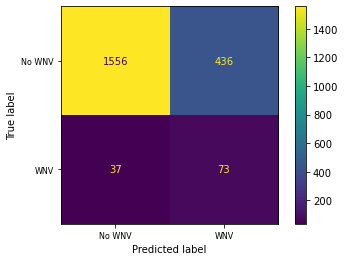

In [12]:
cm = confusion_matrix(y_test, y_pred, labels = lr_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


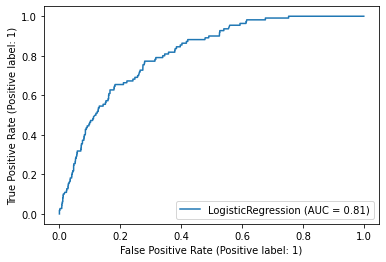

In [13]:
plot_roc_curve(lr_clf, X_test, y_test)

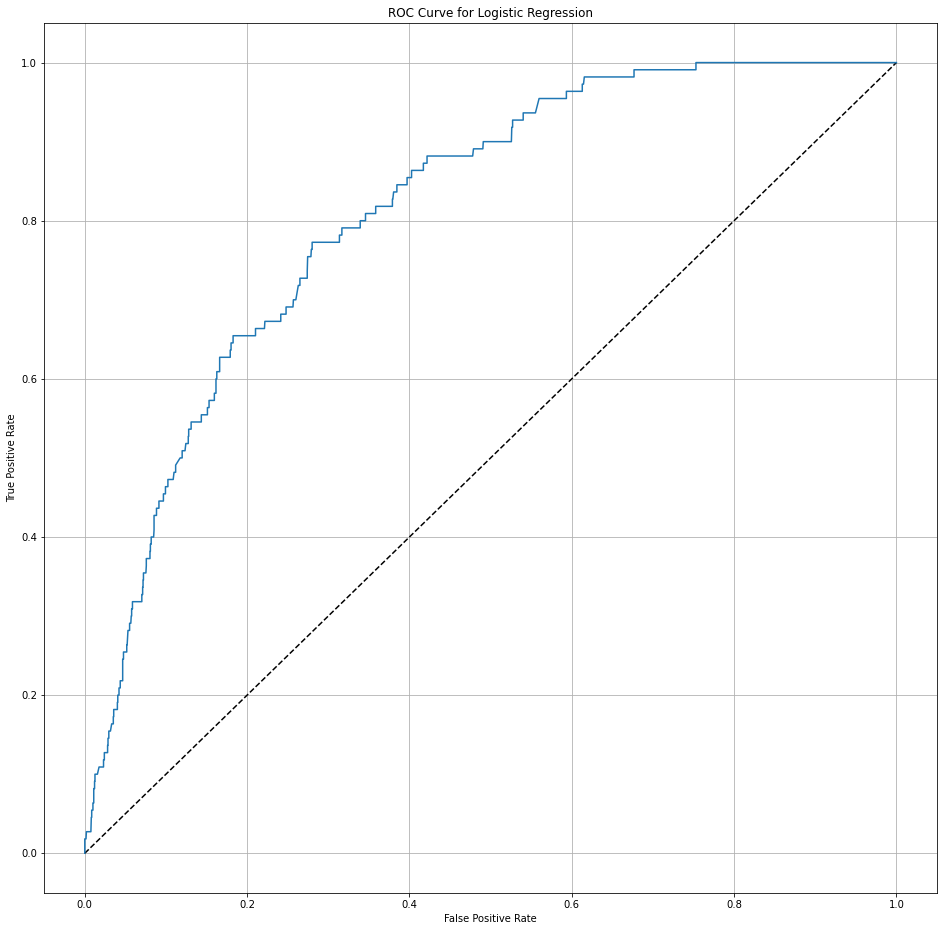

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.grid(True)
plt.show()

#### Hyperparameter Tuning Using GridSearchCV

In [15]:
#Define the search space
params={
        'solver': ['newton-cg', 'liblinear'],
        'C': [0.75, 1],
        'penalty': ['l1', 'l2']
    }

In [16]:
#Create classifier and define grid search
lr_clf = LogisticRegression()
lr_gs = GridSearchCV(lr_clf, params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)

In [17]:
#Fit grid search and get best parameters
lr_gs.fit(X_train, y_train)
best_est = lr_gs.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END C=0.75, penalty=l1, solver=newton-cg;, score=nan total time=   0.1s
[CV 2/3] END C=0.75, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.75, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/3] END C=0.75, penalty=l2, solver=liblinear;, score=0.879 total time=   0.4s
[CV 2/3] END C=0.75, penalty=l2, solver=liblinear;, score=0.891 total time=   0.4s
[CV 1/3] END ...C=1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/3] END ...C=1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END ...C=1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/3] END C=0.75, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.8s
[CV 3/3] END C=0.75, penalty=l2, solver=liblinear;, score=0.887 total time=   0.3s
[CV 2/3] END C=0.75, penalty=l2, solver=newton-cg;, score=0.891 total time=   0.7s
[CV 1/3] END C=0.75, penalty=l2, solver


6 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/louistomczak/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/louistomczak/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/louistomczak/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver
    raise ValueError(
ValueError: Solver newton-cg supports only 'l2' or 'non

In [18]:
#display best estimators
print(best_est)

LogisticRegression(C=1, penalty='l1', solver='liblinear')


In [19]:
print(lr_gs.best_score_)

0.8934231462011378


In [20]:
#Make prediction and get predicted probabilities
y_pred_probs_gs = lr_gs.predict_proba(X_test)[:,1]

In [21]:
#Get performance metrics
roc_auc_score(y_test, y_pred_probs_gs)

0.8147316538882803

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


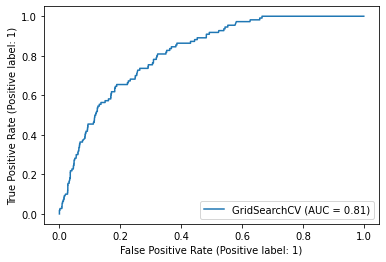

In [22]:
plot_roc_curve(lr_gs, X_test, y_test)

# 2. Random Forest Classifier

#### Fit Random Forest Classifier

In [23]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state = 42,n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
y_pred_training = rf_clf.predict(X_train)
y_pred_probs = rf_clf.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_probs)

0.7546983388097847

In [24]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7963
           1       0.98      0.99      0.99      7963

    accuracy                           0.99     15926
   macro avg       0.99      0.99      0.99     15926
weighted avg       0.99      0.99      0.99     15926



In [25]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1992
           1       0.17      0.36      0.23       110

    accuracy                           0.87      2102
   macro avg       0.57      0.63      0.58      2102
weighted avg       0.92      0.87      0.89      2102



#### Create Confusion Matrix Plots

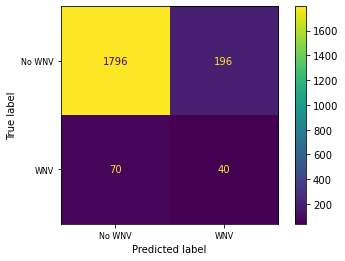

In [26]:
cm = confusion_matrix(y_test, y_pred, labels = rf_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


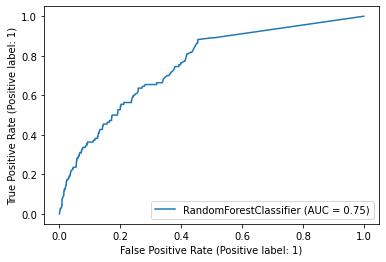

In [27]:
plot_roc_curve(rf_clf, X_test, y_test)

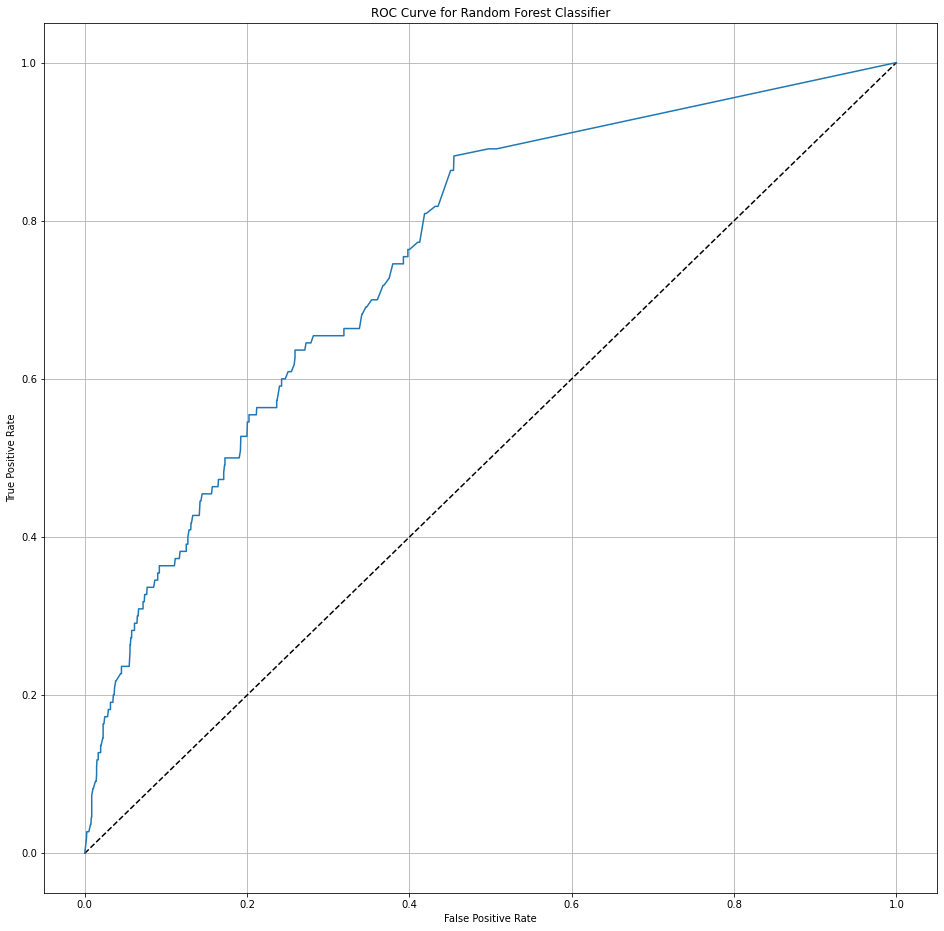

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.grid(True)
plt.show()

#### Plot Feature Importances

30


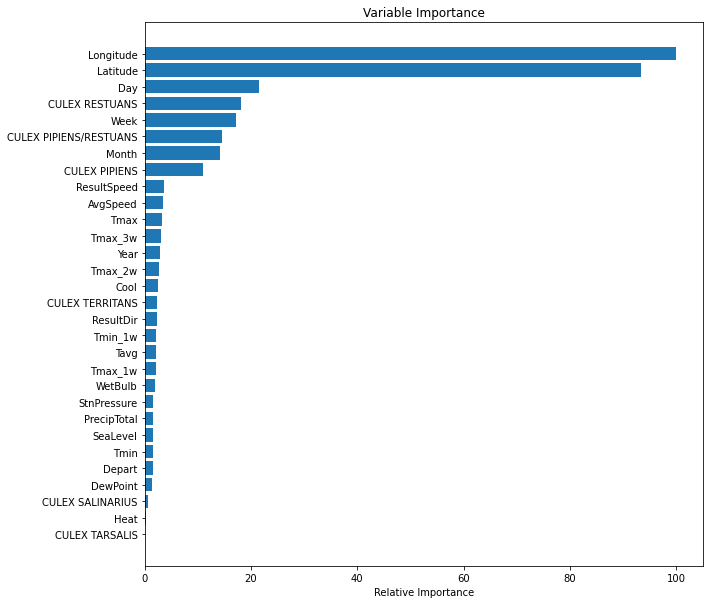

In [29]:
feature_importance = rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Using SHAP

In [30]:
#shap.initjs()

#explainer = shap.TreeExplainer(rf_clf)
#shap_values = explainer.shap_values(X_train)
#shap.summary_plot(shap_values,X_train, max_display=40)

#### Hyperparameter Tuning Using GridSearchCV

In [31]:
#Define the search space
params={
        'bootstrap': [False],
        'max_depth': [10],
        'n_estimators': [2500], 
    }

In [32]:
#Create classifier and define grid search
rf_clf = RandomForestClassifier()
rf_gs = GridSearchCV(rf_clf, params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)

In [33]:
#Fit grid search and get best parameters
rf_gs.fit(X_train, y_train)
best_est = rf_gs.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END bootstrap=False, max_depth=10, n_estimators=2500;, score=0.941 total time=  34.2s
[CV 3/3] END bootstrap=False, max_depth=10, n_estimators=2500;, score=0.936 total time=  34.3s
[CV 1/3] END bootstrap=False, max_depth=10, n_estimators=2500;, score=0.926 total time=  34.4s


In [34]:
#display best estimators
print(best_est)

RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=2500)


In [35]:
print(rf_gs.best_score_)

0.9343147998187001


In [36]:
#Make prediction and get predicted probabilities
y_pred_probs_gs = rf_gs.predict_proba(X_test)[:,1]

In [37]:
#Get performance metrics
roc_auc_score(y_test, y_pred_probs_gs)

0.8177573932092004

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


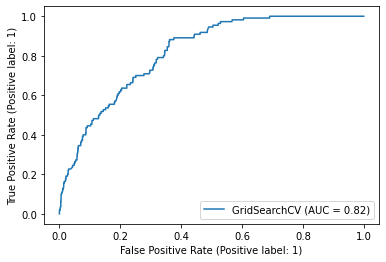

In [38]:
plot_roc_curve(rf_gs, X_test, y_test)

# 3. Extreme Gradient Boosting

#### Fit XGB Classifier

In [39]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_pred_training = xgb_clf.predict(X_train)
y_pred_probs = xgb_clf.predict_proba(X_test)[:,1]


roc_auc_score(y_test, y_pred_probs)

0.8116100766703177

In [40]:
print("Classification Report for Training Data")
print(classification_report(y_train, y_pred_training))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      7963
           1       0.97      0.98      0.97      7963

    accuracy                           0.97     15926
   macro avg       0.97      0.97      0.97     15926
weighted avg       0.97      0.97      0.97     15926



In [41]:
print("Classification Report for Test Data")
print(classification_report(y_test, y_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1992
           1       0.22      0.30      0.25       110

    accuracy                           0.91      2102
   macro avg       0.59      0.62      0.60      2102
weighted avg       0.92      0.91      0.91      2102



#### Create Confusion Matrix Plots

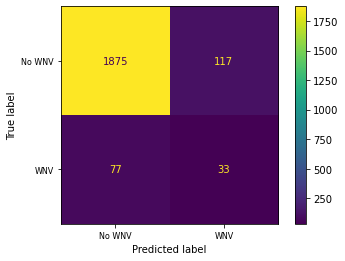

In [42]:
cm = confusion_matrix(y_test, y_pred, labels = xgb_clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['No WNV', 'WNV'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
ax.set_yticklabels(labels = ['No WNV', 'WNV'], fontsize = 8)
display_cm.plot(ax = ax)

#### Plot ROC

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


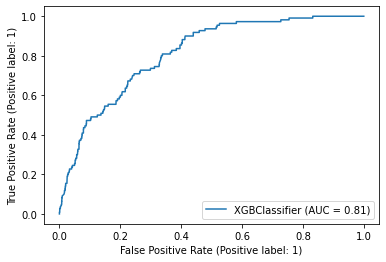

In [43]:
plot_roc_curve(xgb_clf, X_test, y_test)

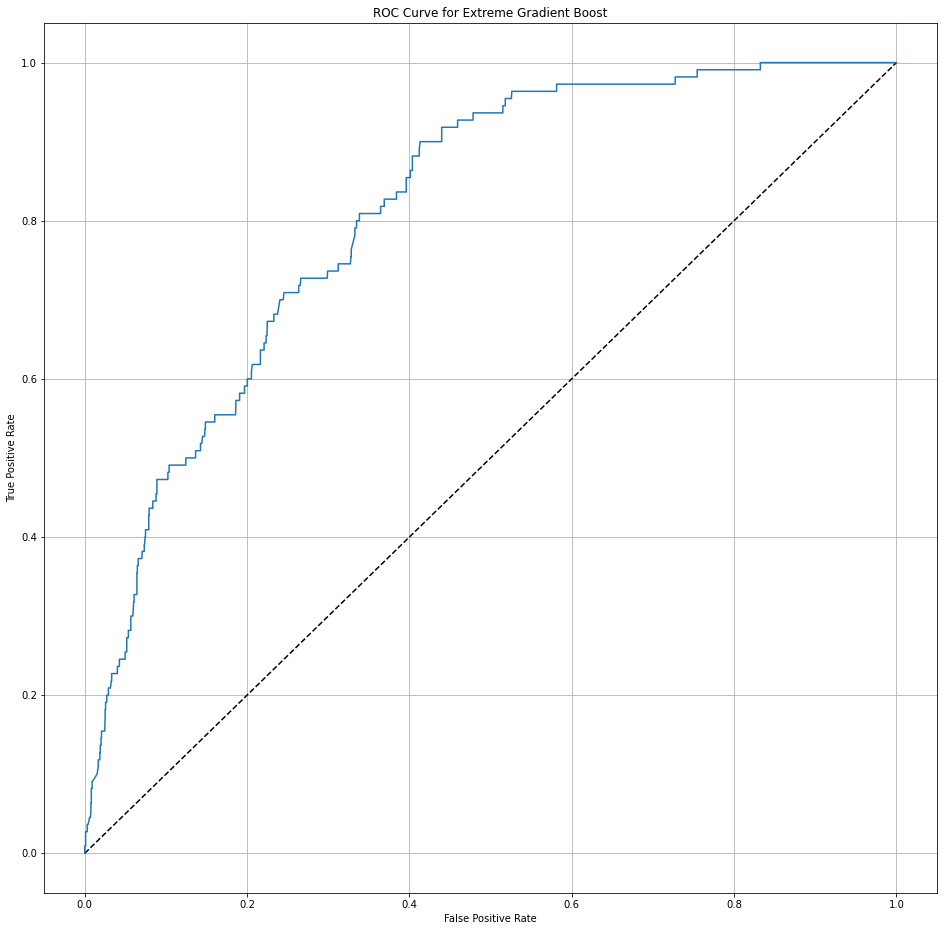

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.subplots(figsize = (16,16))
plt.plot([0,1], [0,1], 'k--')

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Extreme Gradient Boost')
plt.grid(True)
plt.show()

#### Plot Feature Importances

30


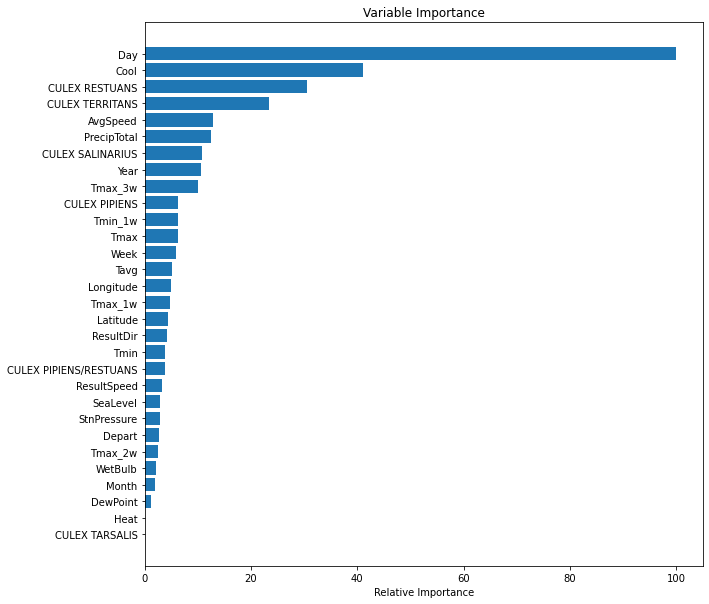

In [45]:
feature_importance = xgb_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:40]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Using SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


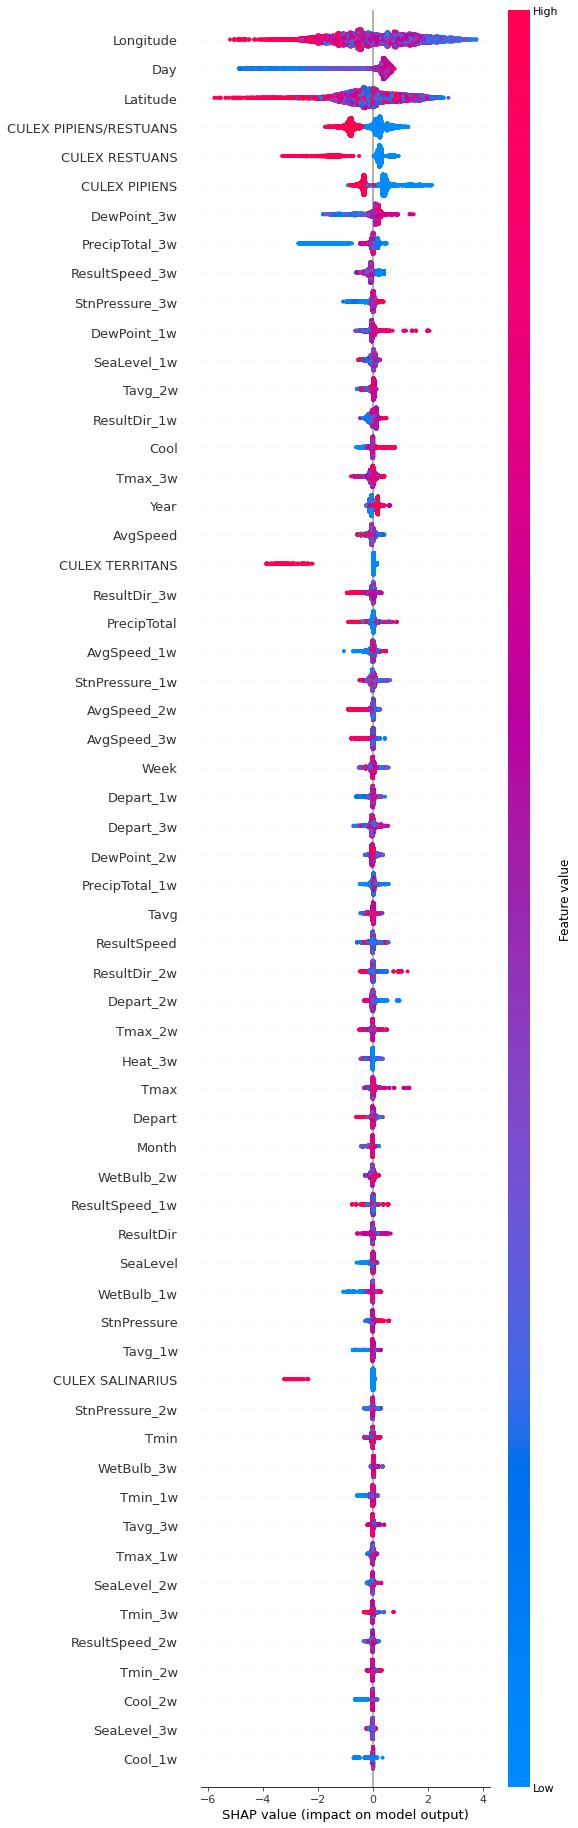

In [46]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train, max_display=60)

#### Hyperparameter Tuning Using GridSearchCV

In [47]:
#Define the search space
params={
        'max_depth': [7], 
        'n_estimators': [100], 
        'learning_rate': [0.0001],
        'scale_pos_weight': [1],
        'colsample_bytree': [.5],
        'subsample': [.5]
    }

In [48]:
#Create classifier and define grid search
xgb_clf = xgb.XGBClassifier()
xgb_gs = GridSearchCV(xgb_clf, params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=3)

In [49]:
#Fit grid search and get best parameters
xgb_gs.fit(X_train, y_train)
best_est = xgb_gs.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.5, learning_rate=0.0001, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.5;, score=0.897 total time=   3.1s
[CV 3/3] END colsample_bytree=0.5, learning_rate=0.0001, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.5;, score=0.901 total time=   3.1s
[CV 2/3] END colsample_bytree=0.5, learning_rate=0.0001, max_depth=7, n_estimators=100, scale_pos_weight=1, subsample=0.5;, score=0.911 total time=   3.1s


In [50]:
#display best estimators
print(best_est)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [51]:
print(xgb_gs.best_score_)

0.9030604344815357


In [52]:
#Make prediction and get predicted probabilities
y_pred_probs_gs = xgb_gs.predict_proba(X_test)[:,1]

In [53]:
#Get performance metrics
roc_auc_score(y_test, y_pred_probs_gs)

0.8199571011317999

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.


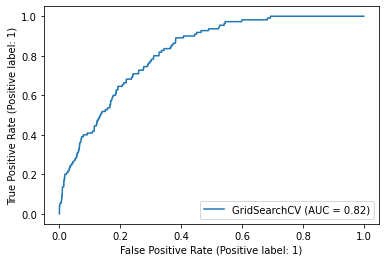

In [54]:
plot_roc_curve(xgb_gs, X_test, y_test)

#### 1. Using GridSearchCV, Random Forest performance boosted significantly and is now my best model at ~ AUC = 0.82. This is surprising and makes me think something is wrong.
#### Why wouldn't XGBoost be able to outperform this, or am I tuning incorrectly?